This notebook can be used to create, train, validate and test the Neural Network.

Add the needed packages:

In [1]:
import os
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchinfo import summary

from NN_config import Config
from HD_DataLoader import *
from NN_model import *


Load in the database and create the training, validation, and test set according to the chosen iteration, and input values:

In [3]:
# Creating the dataset
folder_path = os.path.join(os.getcwd(), 'HD_data') 
HD_class = HD(data_path = folder_path)

# Dataset parameters
version = 1                                             # With version '1' train on all HDs with '2' keep one faulty and one normal HD seperate for testing
Mic = False                                             # Inlcude mic data with True or exclude with False
Curr = True                                             # Inlcude mic data with True or exclude with False
features_domain = {'Mic': 'freq', 'dSpace': 'time'}     # Select either 'time' or 'freq'

if version==1:
    db_train_and_test = HD_class.generate_database()

    # The use of microphone data is set as well as current data can be set to True or False, and the domain in which they are used can be set to Frequency or Time
    dataset = StatisticalFeaturesDataset(db_train_and_test, window_sec=2, selected_domain = features_domain, Mic_bool=Mic, Curr_bool=Curr)
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True)
    train_dataset, val_dataset = train_test_split(dataset, test_size=0.3, random_state=42, shuffle=True)

elif version==2:
    db_train, db_test = HD_class.generate_database_test_train()

    # The use of microphone data is set as well as current data can be set to True or False, and the domain in which they are used can be set to Frequency or Time
    dataset_train = StatisticalFeaturesDataset(db_train, window_sec=2, selected_domain = features_domain, Mic_bool=Mic, Curr_bool=Curr)
    train_dataset, val_dataset = train_test_split(dataset_train, test_size=0.3, random_state=42, shuffle=True)
    test_dataset = StatisticalFeaturesDataset(db_test, window_sec=2, selected_domain = features_domain, Mic_bool=Mic, Curr_bool=Curr)

# Creating data loaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

---------------------------------------------------------
Generating database for HD's


Create the Neural Network:

In [4]:
train_features, train_labels = next(iter(train_dataloader))
input_dim = train_features.shape[1]
print('The input dimension: ' + str(input_dim))
print('The amound of batches in the train loaders: ' + str(len(train_dataloader)))
      
cfg = Config()

# Initialize network
model = Classifier(input_dim)
model.train()
if cfg.enable_cuda:
    model = model.cuda()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

summary(model,input_size=(batch_size,input_dim))

The input dimension: 6
The amound of batches in the train loaders: 16


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [32, 1]                   --
├─Linear: 1-1                            [32, 20]                  140
├─Linear: 1-2                            [32, 40]                  840
├─Linear: 1-3                            [32, 20]                  820
├─Linear: 1-4                            [32, 1]                   21
├─Sigmoid: 1-5                           [32, 1]                   --
Total params: 1,821
Trainable params: 1,821
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.03

Train the NN

In [8]:
# Track losses
train_losses = []
val_losses = []
i = 0

for epoch in range(cfg.num_epochs):
    
    #Training phase
    model.train()  # Set the model in training mode
    epoch_train_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.float().reshape(-1,1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()

    # Validation phase
    model.eval()  # Set the model in evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
            for i, data in enumerate(val_dataloader,0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                labels = labels.float().reshape(-1,1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = (outputs >= 0.5).squeeze().long()
                total += labels.size(0)
                correct += predicted.eq(labels.squeeze()).sum().item()

    # Print training validation metrics
    val_loss /= len(val_dataloader)
    val_acc = correct / total * 100
    train_loss = epoch_train_loss / len(train_dataloader)

    print(f"Epoch [{epoch + 1}/{cfg.num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    
    # Store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

print("Finished training.")
save_path = 'model.pt'
torch.save(model.state_dict(), save_path)
print("Saved trained model as {}.".format(save_path))

Epoch [1/100], Training Loss: 0.0631, Validation Loss: 0.0732, Validation Accuracy: 94.91%
Epoch [2/100], Training Loss: 0.0635, Validation Loss: 0.0634, Validation Accuracy: 94.91%
Epoch [3/100], Training Loss: 0.0635, Validation Loss: 0.0562, Validation Accuracy: 96.76%
Epoch [4/100], Training Loss: 0.0694, Validation Loss: 0.0710, Validation Accuracy: 94.91%
Epoch [5/100], Training Loss: 0.0617, Validation Loss: 0.0631, Validation Accuracy: 94.91%
Epoch [6/100], Training Loss: 0.0658, Validation Loss: 0.0804, Validation Accuracy: 94.91%
Epoch [7/100], Training Loss: 0.0687, Validation Loss: 0.0609, Validation Accuracy: 96.76%
Epoch [8/100], Training Loss: 0.0636, Validation Loss: 0.0622, Validation Accuracy: 94.91%
Epoch [9/100], Training Loss: 0.0667, Validation Loss: 0.0582, Validation Accuracy: 96.30%
Epoch [10/100], Training Loss: 0.0636, Validation Loss: 0.0606, Validation Accuracy: 94.91%
Epoch [11/100], Training Loss: 0.0596, Validation Loss: 0.0731, Validation Accuracy: 94.9

Plot the losses:

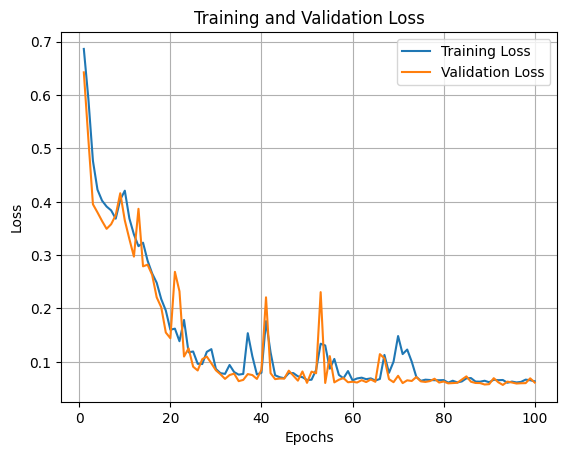

In [6]:
plt.plot(range(1, cfg.num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, cfg.num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

Test the model

In [7]:
correct = 0
total = 0

# track false positive rate and false negative rate
false_positive = 0
true_positive = 0
false_negative = 0
true_negative = 0

print("Starting evaluation with the test set...")

with torch.no_grad():
    for i, data in enumerate(test_dataloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.float().reshape(-1,1)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        predicted = (outputs >= 0.5).squeeze().long()
        total += labels.size(0)
        correct += predicted.eq(labels.squeeze()).sum().item()
        
        for i in range(len(predicted)):
                    if predicted[i] == 1 and labels[i] == 0:
                        false_positive += 1
                    elif predicted[i] == 0 and labels[i] == 1:
                        false_negative += 1
                    elif predicted[i] == 1 and labels[i] == 1:
                        true_positive += 1
                    elif predicted[i] == 0 and labels[i] == 0:
                        true_negative += 1

print("Accuracy of the network on the {} test images: {} %".format(total, round((correct/total*100), 1)) )
print("Correct predictions: {}".format(correct))
print("Total predictions: {}".format(total))

false_positive_rate = false_positive / (false_positive + true_negative)
false_negative_rate = false_negative / (false_negative + true_positive)

print("False positive rate: " + str(false_positive_rate))
print("False negative rate: " + str(false_negative_rate))
print("Percentage of positively predicted samples: " + str((false_positive + true_positive) / total))

Starting evaluation with the test set...
Accuracy of the network on the 144 test images: 94.4 %
Correct predictions: 136
Total predictions: 144
False positive rate: 0.0
False negative rate: 0.0975609756097561
Percentage of positively predicted samples: 0.5138888888888888
